@nipdep
## Model architecture 

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import RandomNormal, HeUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, Activation, Dropout, BatchNormalization, LeakyReLU, GlobalMaxPool2D, Concatenate, ReLU, AveragePooling2D, GaussianNoise
from tensorflow.keras import losses

In [2]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = HeUniform()
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [3]:
def define_decoder_block(layer_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    # g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g

In [4]:
def define_generator(latent_size, image_shape=(128, 128, 2)):
    init = RandomNormal(stddev=0.02)
    input_image = Input(shape=image_shape)
    noised_input = GaussianNoise(0.01)(input_image)
#     style_image = Input(shape=image_shape)
    # stack content and style images
#     stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(noised_input, 32, batchnorm=False)
    e2 = define_encoder_block(e1, 64)
    e3 = define_encoder_block(e2, 128)
    e4 = define_encoder_block(e3, 256)
    e5 = define_encoder_block(e4, 256)
    e6 = define_encoder_block(e5, 256)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, 256)
    d3 = define_decoder_block(d2, 256)
    d4 = define_decoder_block(d3, 256, dropout=False)
    d5 = define_decoder_block(d4, 128, dropout=False)
    d6 = define_decoder_block(d5, 64, dropout=False)
    d7 = define_decoder_block(d6, 32, dropout=False)
    #output layer
    g = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('sigmoid')(g)
    model = Model(inputs=input_image, outputs=out_image, name='generator')
    return model

In [5]:
model = define_generator(32, (128,128,2))

In [6]:
model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1056      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0 

## Dataset & dataLoader

In [7]:
train_data = np.load('../../data/data/train_data.npz')
fimg_data = train_data['first_image']
simg_data = train_data['second_image']
mask_data = train_data['mask']

In [8]:
fimg_data.shape

(848, 256, 256, 3)

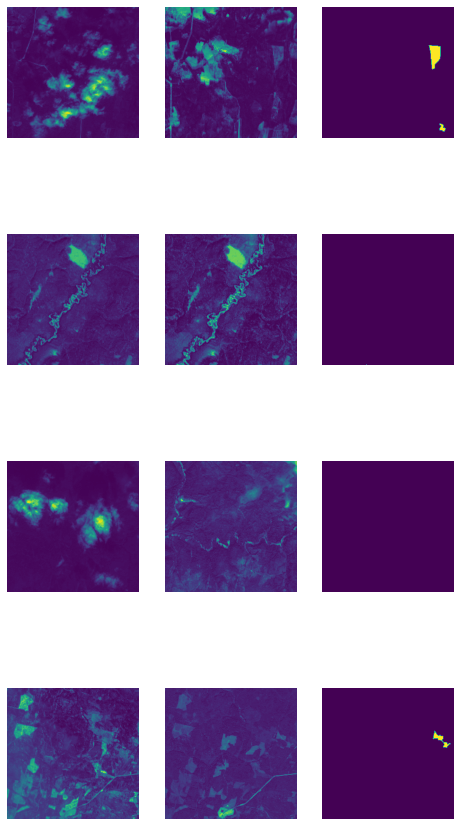

In [19]:
n = 4
rnd_inds = random.sample(range(0,840),n)
plt.figure(figsize=(8,16))

for i in range(n):
    plt.subplot(n, 3, 3*i+1)
    plt.axis('off')
    plt.imshow(fimg_data[rnd_inds[i]][...,0])

    plt.subplot(n, 3, 3*i+2)
    plt.axis('off')
    plt.imshow(simg_data[rnd_inds[i]][...,1])

    plt.subplot(n, 3, 3*i+3)
    plt.axis('off')
    plt.imshow(mask_data[rnd_inds[i]])


In [9]:
## Optional to channel selection
f_np = fimg_data[...,0]
s_np = simg_data[...,1]

In [57]:
## Optional to run
def set_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

f_np = np.array([set_gray(img) for img in fimg_data])
s_np = np.array([set_gray(img) for img in simg_data])

In [10]:
ff_np = np.expand_dims(f_np, 0)
sf_np = np.expand_dims(s_np, 0)
c_np = np.vstack((ff_np, sf_np))
n_np = np.moveaxis(c_np, [0,1,2,3], [3,0,1,2])
n_np.shape

(848, 256, 256, 2)

In [11]:
ff_np.shape

(1, 848, 256, 256)

In [12]:
train_X = tf.data.Dataset.from_tensor_slices(n_np)
mask_y = tf.data.Dataset.from_tensor_slices(np.expand_dims(mask_data, -1))

In [13]:
train_dt = tf.data.Dataset.zip((train_X, mask_y))
train_dt.element_spec

(TensorSpec(shape=(256, 256, 2), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint16, name=None))

In [14]:

def normalize(img, mask):
    # one, zero = tf.ones_like(mask), tf.zeros_like(mask)
    img = img/255
    # mask = mask/tf.math.reduce_max(mask)
    # mask = tf.where(mask > 0.0, x=one, y=zero)
    return tf.cast(img, dtype=tf.float32), tf.cast(mask, dtype=tf.float32)

def rescale(img, mask, scale=(128,128)):
    img = tf.image.resize(img, scale, preserve_aspect_ratio=True, antialias=True)
    mask = tf.image.resize(mask, scale, preserve_aspect_ratio=True, antialias=True)
    return tf.cast(img, dtype=tf.float32), tf.cast(mask, dtype=tf.float32)


def brightness(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_brightness(img1, 0.1)
#     img2 = tf.image.adjust_brightness(img2, 0.1)
    return img1, mask

def gamma(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_gamma(img1, 0.1)
#     img2 = tf.image.adjust_gamma(img2, 0.1) 
    return img1, mask

def hue(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_hue(img1, -0.1)
#     img2 = tf.image.adjust_hue(img2, -0.1)
    return img1, mask

# def crop(img, mask):
#      img = tf.image.central_crop(img, 0.7)
#      img = tf.image.resize(img, (128,128))
#      mask = tf.image.central_crop(mask, 0.7)
#      mask = tf.image.resize(mask, (128,128))
#      mask = tf.cast(mask, tf.uint8)
#      return img, mask

def flip_hori(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_left_right(img1)
#     img2 = tf.image.flip_left_right(img2)
        mask = tf.image.flip_left_right(mask)
    return img1, mask

def flip_vert(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_up_down(img1)
#     img2 = tf.image.flip_up_down(img2)
        mask = tf.image.flip_up_down(mask)
    return img1, mask

def rotate(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.rot90(img1)
#     img2 = tf.image.rot90(img2)
        mask = tf.image.rot90(mask)
    return img1, mask
# %%
# perform augmentation on train data only
train_dt = train_dt.map(normalize)
train_dt = train_dt.map(rescale)
a = train_dt.map(brightness)
b = train_dt.map(gamma)
e = train_dt.map(flip_hori)
f = train_dt.map(flip_vert)
g = train_dt.map(rotate)

train_dt = train_dt.concatenate(a)
train_dt = train_dt.concatenate(b)
train_dt = train_dt.concatenate(e)
train_dt = train_dt.concatenate(f)
train_dt = train_dt.concatenate(g) 

input image shape :  (128, 128, 2) mask image shape :  (128, 128, 1)


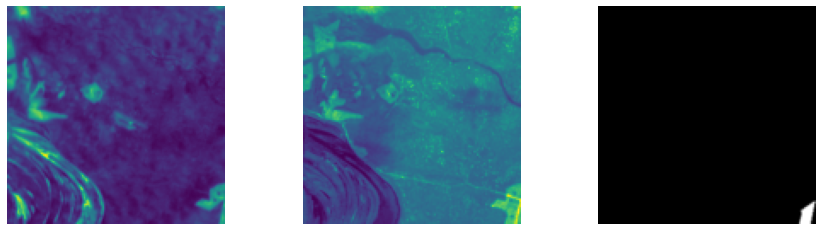

In [17]:
sample = train_dt.take(3)
sample_imgs = list(sample.as_numpy_iterator())
input_imgs = sample_imgs[2][0]
mask_img = sample_imgs[2][1]

plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(input_imgs[:, :, 0])

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(input_imgs[:, :, 1])

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(mask_img, cmap='gray', vmin=0, vmax=1)
fir_img = input_imgs[:, :,0]

## Model Training

In [18]:
BATCH = 32
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train_dt = train_dt.cache().shuffle(BUFFER).batch(BATCH).repeat()
train_dt = train_dt.prefetch(buffer_size=AT)

In [22]:
model = define_generator(32, (128,128,2))
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(5e-5),
             metrics=['accuracy']) 

In [15]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 11s 125ms/step - loss: 0.6909 - accuracy: 0.5893
Epoch 2/10
25/25 [==============================] - 3s 126ms/step - loss: 0.6432 - accuracy: 0.8758
Epoch 3/10
25/25 [==============================] - 3s 123ms/step - loss: 0.6076 - accuracy: 0.9517
Epoch 4/10
25/25 [==============================] - 3s 125ms/step - loss: 0.5779 - accuracy: 0.9714
Epoch 5/10
25/25 [==============================] - 3s 126ms/step - loss: 0.5510 - accuracy: 0.9834
Epoch 6/10
25/25 [==============================] - 3s 125ms/step - loss: 0.5258 - accuracy: 0.9866
Epoch 7/10
25/25 [==============================] - 3s 125ms/step - loss: 0.5035 - accuracy: 0.9868
Epoch 8/10
25/25 [==============================] - 3s 125ms/step - loss: 0.4800 - accuracy: 0.9873
Epoch 9/10
25/25 [==============================] - 3s 125ms/step - loss: 0.4543 - accuracy: 0.9874
Epoch 10/10
25/25 [==============================] - 3s 125ms/step - loss: 0.4283 - accuracy: 0.988

In [28]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

In [29]:
print(f_imgs.shape, mask_img.shape)

(32, 128, 128, 2) (32, 128, 128, 1)


In [30]:
pred.shape

(32, 128, 128, 1)

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


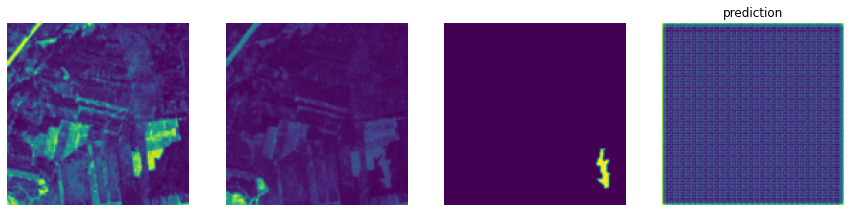

In [33]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[14, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[14, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[14])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[14])

using huber loss function

In [14]:
model = define_generator(32, (128,128,2))
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [15]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 7s 147ms/step - loss: 0.0890 - root_mean_squared_error: 0.4220
Epoch 2/10
25/25 [==============================] - 4s 146ms/step - loss: 0.0345 - root_mean_squared_error: 0.2626
Epoch 3/10
25/25 [==============================] - 4s 148ms/step - loss: 0.0154 - root_mean_squared_error: 0.1757
Epoch 4/10
25/25 [==============================] - 4s 149ms/step - loss: 0.0095 - root_mean_squared_error: 0.1377
Epoch 5/10
25/25 [==============================] - 4s 151ms/step - loss: 0.0074 - root_mean_squared_error: 0.1215
Epoch 6/10
25/25 [==============================] - 4s 150ms/step - loss: 0.0057 - root_mean_squared_error: 0.1068
Epoch 7/10
25/25 [==============================] - 4s 150ms/step - loss: 0.0053 - root_mean_squared_error: 0.1030
Epoch 8/10
25/25 [==============================] - 4s 151ms/step - loss: 0.0046 - root_mean_squared_error: 0.0961
Epoch 9/10
25/25 [==============================] - 4s 151ms/step - loss: 0.0048

In [16]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


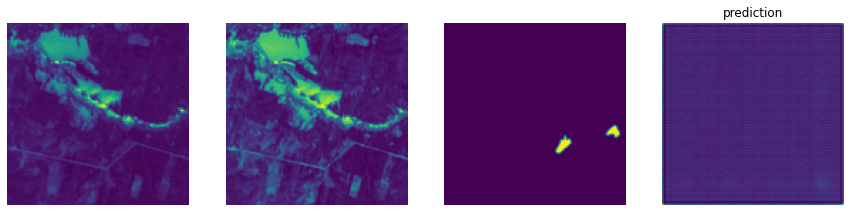

In [18]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[8, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[8, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[8])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[8])

using mean squared logarithm error

In [31]:
model = define_generator(32, (128,128,2))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.SGD(5e-3),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [32]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=5)

Epoch 1/5
25/25 [==============================] - 3s 91ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
Epoch 2/5
25/25 [==============================] - 2s 92ms/step - loss: 0.1979 - root_mean_squared_error: 0.4448
Epoch 3/5
25/25 [==============================] - 2s 92ms/step - loss: 0.1714 - root_mean_squared_error: 0.4139
Epoch 4/5
25/25 [==============================] - 2s 93ms/step - loss: 0.1501 - root_mean_squared_error: 0.3874
Epoch 5/5
25/25 [==============================] - 2s 92ms/step - loss: 0.1330 - root_mean_squared_error: 0.3646


In [33]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


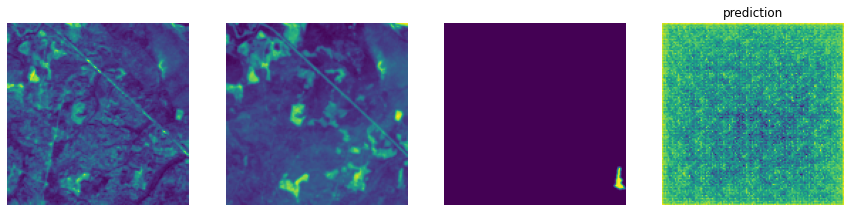

In [34]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[8, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[8, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[8])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[8])

using hinge loss function

In [ ]:
model.compile(loss=tf.keras.losses.Hinge(),
             optimizer=keras.optimizers.Adam(5e-3),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [33]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=5)

Epoch 1/5
25/25 [==============================] - 5s 127ms/step - loss: 0.9930 - root_mean_squared_error: 0.9412
Epoch 2/5
25/25 [==============================] - 3s 126ms/step - loss: 0.9914 - root_mean_squared_error: 0.9942
Epoch 3/5
25/25 [==============================] - 3s 126ms/step - loss: 0.9921 - root_mean_squared_error: 0.9952
Epoch 4/5
25/25 [==============================] - 3s 126ms/step - loss: 0.9925 - root_mean_squared_error: 0.9955
Epoch 5/5
25/25 [==============================] - 3s 126ms/step - loss: 0.9918 - root_mean_squared_error: 0.9951


In [34]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


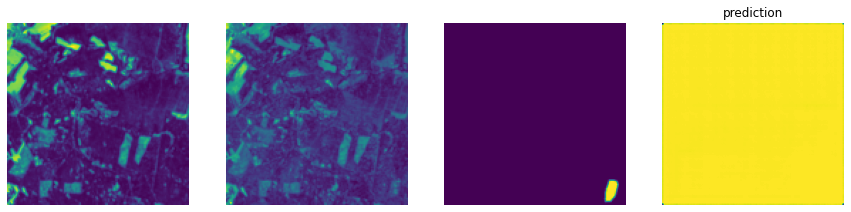

In [35]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[7, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[7, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[7])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[7])

### Using Dice-loss function

In [40]:
smooth = 1. # Used to prevent denominator 0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) # y_true stretch to one dimension
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [43]:
model = define_generator(32, (128,128,2))
model.compile(loss=dice_coef_loss,
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [44]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 4s 96ms/step - loss: 0.9614 - root_mean_squared_error: 0.4380
Epoch 2/10
25/25 [==============================] - 2s 97ms/step - loss: 0.9321 - root_mean_squared_error: 0.2644
Epoch 3/10
25/25 [==============================] - 2s 97ms/step - loss: 0.8864 - root_mean_squared_error: 0.1394
Epoch 4/10
25/25 [==============================] - 2s 99ms/step - loss: 0.8835 - root_mean_squared_error: 0.1092
Epoch 5/10
25/25 [==============================] - 2s 100ms/step - loss: 0.8671 - root_mean_squared_error: 0.1142
Epoch 6/10
25/25 [==============================] - 2s 95ms/step - loss: 0.8835 - root_mean_squared_error: 0.1035
Epoch 7/10
25/25 [==============================] - 2s 95ms/step - loss: 0.8530 - root_mean_squared_error: 0.1133
Epoch 8/10
25/25 [==============================] - 2s 95ms/step - loss: 0.8323 - root_mean_squared_error: 0.1103
Epoch 9/10
25/25 [==============================] - 2s 95ms/step - loss: 0.8429 - root_

In [45]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


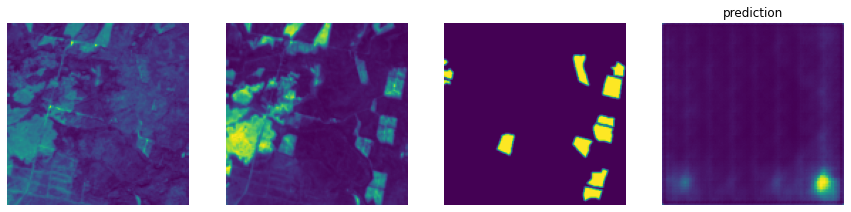

In [49]:
plt.figure(figsize=(15,4))
i = 10
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[i, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[i, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[i])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[i])